In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/Zomato-data-.csv')

In [3]:
df.head()

,name,online_order,book_table,rate,votes,approx_cost(for two people),listed_in(type)
0,Jalsa,Yes,Yes,4.1/5,775,800,Buffet
1,Spice Elephant,Yes,No,4.1/5,787,800,Buffet
2,San Churro Cafe,Yes,No,3.8/5,918,800,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7/5,88,300,Buffet
4,Grand Village,No,No,3.8/5,166,600,Buffet


### Data Cleaning
1. Convert the rate column to a float by removing denominator characters.

In [4]:
def handle_rate(rate):
    if isinstance(rate, str):
        rate = rate.split('/')[0].strip()  # Take the first part before '/'
        rate = rate.replace(',', '.')  # Replace comma with dot for float conversion
        try:
            return float(rate)
        except ValueError:
            return np.nan
    return np.nan

In [5]:
df['rate'] = df['rate'].apply(handle_rate)

In [6]:
df.head()

,name,online_order,book_table,rate,votes,approx_cost(for two people),listed_in(type)
0,Jalsa,Yes,Yes,4.1,775,800,Buffet
1,Spice Elephant,Yes,No,4.1,787,800,Buffet
2,San Churro Cafe,Yes,No,3.8,918,800,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7,88,300,Buffet
4,Grand Village,No,No,3.8,166,600,Buffet


2. Getting summary of the dataframe

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         148 non-null    object 
 1   online_order                 148 non-null    object 
 2   book_table                   148 non-null    object 
 3   rate                         148 non-null    float64
 4   votes                        148 non-null    int64  
 5   approx_cost(for two people)  148 non-null    int64  
 6   listed_in(type)              148 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 8.2+ KB


there is no null values in the dataframe ans data types are appropriate

In [8]:
df.describe()

,rate,votes,approx_cost(for two people)
count,148.000000,148.000000,148.000000
mean,3.633108,264.810811,418.243243
std,0.402271,653.676951,223.085098
min,2.600000,0.000000,100.000000
25%,3.300000,6.750000,200.000000
50%,3.700000,43.500000,400.000000
75%,3.900000,221.750000,600.000000
max,4.600000,4884.000000,950.000000


there doesn't seem to be any outliers in the data, but we can check the distribution of the rate column.

In [9]:
df[df.duplicated()]

,name,online_order,book_table,rate,votes,approx_cost(for two people),listed_in(type)


no duplicates found in the dataframe

In [10]:
df.apply(lambda x: x.unique())

name                           [Jalsa, Spice Elephant, San Churro Cafe, Addhu...
online_order                                                           [Yes, No]
book_table                                                             [Yes, No]
rate                           [4.1, 3.8, 3.7, 3.6, 4.6, 4.0, 4.2, 3.9, 3.1, ...
votes                          [775, 787, 918, 88, 166, 286, 8, 2556, 324, 50...
approx_cost(for two people)    [800, 300, 600, 700, 550, 500, 450, 650, 400, ...
listed_in(type)                                   [Buffet, Cafes, other, Dining]
dtype: object

there doesn't seem tp be any inconsistent values in the dataframe

In [11]:
from scipy import stats

In [12]:
def check_outliers_zscore(df, column, threshold=3):
    non_null = df[column].dropna()
    z_scores = np.abs(stats.zscore(non_null))
    outlier_indices = non_null.index[z_scores > threshold]
    outliers = df.loc[outlier_indices]
    print(f"Outliers in {column}: {len(outliers)} rows")
    return outliers

In [13]:
for column in df.select_dtypes(include=[np.number]).columns:
    outliers = check_outliers_zscore(df, column)
    if not outliers.empty:
        print(outliers[[column]])
    print('-' * 50)

Outliers in rate: 0 rows
--------------------------------------------------
Outliers in votes: 4 rows
    votes
7    2556
38   4884
44   2556
86   4401
--------------------------------------------------
Outliers in approx_cost(for two people): 0 rows
--------------------------------------------------


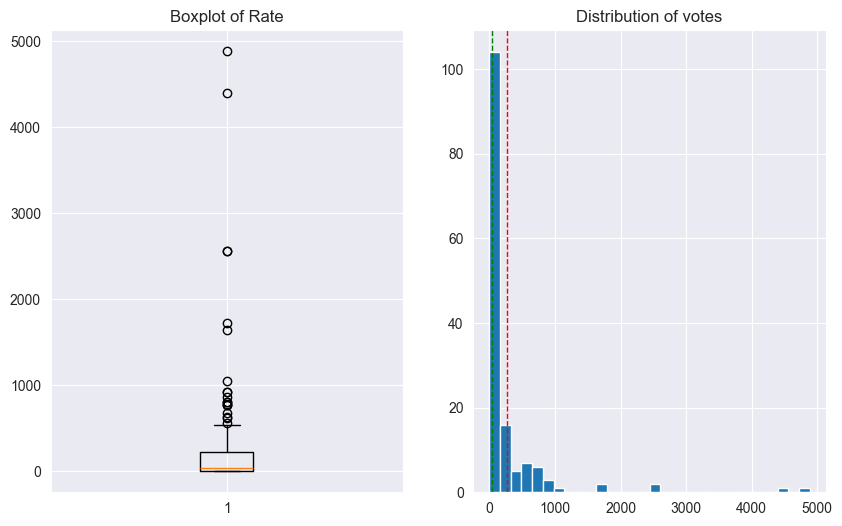

In [14]:
# Boxplot to visualize outliers
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.boxplot(df['votes'].dropna())
plt.title('Boxplot of Rate')

plt.subplot(1, 2, 2)
plt.hist(df['votes'].dropna(), bins=30)
plt.axvline(df['votes'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(df['votes'].median(), color='green', linestyle='dashed', linewidth=1)
plt.title('Distribution of votes')
plt.show()

so there are 4 outliers in the votes column, so let's replace the with the median since our data is right skewed, so we need the robust measure of central tendency. Removing them would result in loss of information since we have only 148 observations.

In [15]:
def replace_outliers_with_median(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column].dropna()))
    outlier_mask = pd.Series(False, index=df.index)
    outlier_mask[df[column].dropna().index] = z_scores > threshold
    df.loc[outlier_mask, column] = df[column].dropna().median()
    return df

In [16]:
df = replace_outliers_with_median(df, 'votes')

/tmp/ipykernel_58873/1313927817.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '43.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outlier_mask, column] = df[column].dropna().median()


so, we cleaned data is ready for analysis, let's save it to a new csv file.

In [18]:
df.to_csv('data/cleaned_zomato_data.csv',
          index=False,
          encoding='utf-8',
          sep=',')